# Advanced Classification Predict 

<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Model Explanations</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>


In [104]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# needed for preprocessing
import re                                # library for regular expressions 
import string                            # for string operations 
from nltk.corpus import stopwords        # module for stopwords that come with NLTK
from nltk.stem import PorterStemmer      # module for stemming 
from nltk.tokenize import TweetTokenizer # module for tokenizing strings 
from nltk import word_tokenize

<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


In [33]:
# Load files
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
samplesubmission = pd.read_csv('sample_submission.csv')

# Preview train dataset
train.head()


,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [34]:
# Preview test dataset
test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [35]:
# Preview sample submission file
samplesubmission.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1


In [36]:
# Check size and shape of datasets
train.shape, test.shape, samplesubmission.shape

((15819, 3), (10546, 2), (10546, 2))

<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

C:\Users\mac07\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


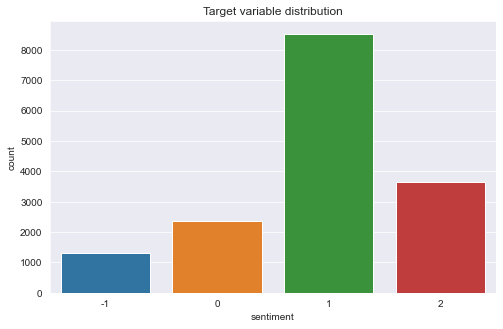

In [37]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
sns.countplot(train["sentiment"])
plt.title('Target variable distribution')
plt.show()

The target variable is not well balanced.
Some of the techniques to handle imbalanceness include:
- Smote
- Oversampling
- Undersampling ...

In [38]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any() 

(False, False)

No missing values 

In [39]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()

(False, False)

No duplicated values 

<a id="four"></a>
## 4. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

### Hashtag Extraction using Regex

In [105]:
df = train.copy()

In [106]:
df['hashtag'] = df['message'].apply(lambda x: re.findall(r'#(\w+)', x))

In [107]:
df.sample(20)

,sentiment,message,tweetid,hashtag
8855,-1,RT @JaredWyand: Steve Bannon means bye bye to ...,578512,[]
7151,2,US climate change campaigner dies snorkeling a...,923994,"[GreatBarrierReef, GreatBarrierReef]"
10280,1,RT @mashable: Trump's order will begin to unra...,319226,[]
15735,1,Here's a new climate change reality that Trump...,69451,[]
6136,1,@SenScottWagner Apparently you don't even have...,227958,[Moron]
13248,0,"Number one, I fully understand why her right n...",462302,[]
8966,2,RT @sciam: Suburbs are increasingly threatened...,833686,[]
9509,-1,@StephzillaNJ because climate change is a myth,546490,[]
14878,-1,@BernieSanders $20 trillion in debt Trumps any...,354386,[]
12648,1,RT @danpfeiffer: Appointing someone who doesn'...,397848,[]


### Tweet-preprocessor 

Tweet preprocessing librrary in Python 

Helps remove:
- Urls
- Mentions 
- Reserved words (RT, FAV)
- Emojis 
- Smileys

In [108]:
# extract all the RT and mentions
df['RT'] = df['message'].apply(lambda x: re.findall(r'^RT[\s]@(\w+):', x))

In [109]:
# remove RT
df['text'] = df['message'].apply(lambda x: re.sub(r'^RT[\s]@(\w+):', '', x))

In [110]:
# remove hastags
df['text'] = df['text'].apply(lambda x : re.sub(r'#(\w+#\s\w+)\s:', '' , x))


In [96]:
df.head()

,sentiment,message,tweetid,hashtag,RT,text
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,[],[],PolySciMajor EPA chief doesn't think carbon di...
1,1,It's not like we lack evidence of anthropogeni...,126103,[],[],It's not like we lack evidence of anthropogeni...
2,2,RT @RawStory: Researchers say we have three ye...,698562,[],[RawStory],Researchers say we have three years to act on...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,[TodayinMaker],[],2016 was a pivotal year in the war on climate...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,[ElectionNight],[SoyNovioDeTodas],"It's 2016, and a racist, sexist, climate chan..."


### Tokenize the string 

To tokenize means to split a string into individual words

In [102]:
# instatiate tokenizer class 
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

df['tweet_tokens'] = df['text'].apply(lambda x : tokenizer.tokenize(tweet) )

In [116]:
tokenizer = word_tokenize('text')

df['tweet_tokens'] = df['text'].apply(lambda x : tokenizer.tokenize(tweet) )

AttributeError: 'list' object has no attribute 'tokenize'

In [103]:
df.head()

,sentiment,message,tweetid,hashtag,RT,text,tweet_tokens
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,[],[],PolySciMajor EPA chief doesn't think carbon di...,"[., ', s, ', climate, change, equation, ', in,..."
1,1,It's not like we lack evidence of anthropogeni...,126103,[],[],It's not like we lack evidence of anthropogeni...,"[., ', s, ', climate, change, equation, ', in,..."
2,2,RT @RawStory: Researchers say we have three ye...,698562,[],[RawStory],Researchers say we have three years to act on...,"[., ', s, ', climate, change, equation, ', in,..."
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,[TodayinMaker],[],2016 was a pivotal year in the war on climate...,"[., ', s, ', climate, change, equation, ', in,..."
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,[ElectionNight],[SoyNovioDeTodas],"It's 2016, and a racist, sexist, climate chan...","[., ', s, ', climate, change, equation, ', in,..."


In [ ]:
# remove the 

df['text'] = re.sub(r'^RT[\s]+')

In [26]:
import preprocessor as p
#forming a separate feature for cleaned tweets
for i,v in enumerate(df['message']):
    df.loc[v,'text'] = p.clean(i)

In [27]:
df.head()

,sentiment,message,tweetid,hashtag,text
0,1.0,PolySciMajor EPA chief doesn't think carbon di...,625221.0,[],NaN
1,1.0,It's not like we lack evidence of anthropogeni...,126103.0,[],NaN
2,2.0,RT @RawStory: Researchers say we have three ye...,698562.0,[],NaN
3,1.0,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736.0,[TodayinMaker],NaN
4,1.0,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954.0,[ElectionNight],NaN


<a id="five"></a>
## 5. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

<a id="six"></a>
## 6. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

<a id="seven"></a>
## 7. Model Explanations
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>